In [3]:
! pip install ultralytics

In [4]:
import os
from PIL import Image
from ultralytics import YOLO

check GPU

In [5]:
!nvidia-smi


Thu Jan 29 17:45:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

installing dependencies

In [6]:
!pip install -U ultralytics opencv-python pillow matplotlib


import and check ultralytics version

In [7]:
from ultralytics import YOLO
import ultralytics

print("Ultralytics version:", ultralytics.__version__)


Ultralytics version: 8.4.8


mount the google drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Fetch the path in the google drive

In [9]:
DATASET_PATH = "/content/drive/MyDrive/CarPartsYoloF"


finding invalid labels

In [10]:
import os

SPLITS = ["train", "valid", "test"]

for split in SPLITS:
    lbl_dir = f"{DATASET_PATH}/{split}/labels"
    print(f"\n🔍 Checking {split}")
    for file in os.listdir(lbl_dir):
        with open(os.path.join(lbl_dir, file)) as f:
            for i, line in enumerate(f):
                n = len(line.strip().split())
                if n <= 5:
                    print(f"❌ {split}/{file} line {i+1}: {n} values")



🔍 Checking train

🔍 Checking valid

🔍 Checking test


converting to polygon, if any in box

In [11]:
def bbox_to_polygon(xc, yc, w, h):
    return [
        xc - w/2, yc - h/2,
        xc + w/2, yc - h/2,
        xc + w/2, yc + h/2,
        xc - w/2, yc + h/2
    ]

for split in SPLITS:
    lbl_dir = f"{DATASET_PATH}/{split}/labels"
    for file in os.listdir(lbl_dir):
        path = os.path.join(lbl_dir, file)
        new_lines = []

        with open(path) as f:
            for line in f:
                data = list(map(float, line.split()))
                cls = int(data[0])

                if len(data) == 5:
                    poly = bbox_to_polygon(*data[1:])
                    new_lines.append(
                        " ".join([str(cls)] + [f"{v:.6f}" for v in poly])
                    )
                else:
                    new_lines.append(line.strip())

        with open(path, "w") as f:
            f.write("\n".join(new_lines))


validation segmentation

In [12]:
for split in SPLITS:
    lbl_dir = f"{DATASET_PATH}/{split}/labels"
    print(f"\n✅ Validating {split}")
    for file in os.listdir(lbl_dir):
        with open(os.path.join(lbl_dir, file)) as f:
            for line in f:
                data = list(map(float, line.split()))
                assert len(data) > 5, "Not a polygon label"
                for v in data[1:]:
                    assert 0 <= v <= 1, "Coordinate not normalized"
    print(f"✔ {split} OK")



✅ Validating train
✔ train OK

✅ Validating valid
✔ valid OK

✅ Validating test
✔ test OK


In [13]:
# Creating the .yaml file

%%writefile /content/data.yaml
path: /content/drive/MyDrive/CarPartsYoloF

train: train/images
val: valid/images
test: test/images

nc: 16
names: ['boot', 'car', 'door', 'front_bumper', 'front_grill', 'front_windshield', 'headlamp', 'hood', 'license_plate', 'panel', 'rear_bumper', 'rear_windshield', 'sideview_mirror', 'taillamp', 'wheel', 'window']


Writing /content/data.yaml


training the yolo v8 model

In [14]:
model = YOLO("yolov8m-seg.pt")

model.train(
    task="segment",
    data="/content/data.yaml",
    epochs=11,
    imgsz=640,
    batch=8,
    patience=20,
    optimizer="AdamW",
    lr0=0.001,
    cos_lr=True,
    device=0,
    cache=True,
    project="/content/drive/MyDrive/runs",
    name="car_parts_seg"
)


Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=11, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=car_parts_seg2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0,

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7edede10b9e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0

In [14]:
# validate the model

model = YOLO("/content/drive/MyDrive/runs/segment/car_parts_seg/weights/best.pt")

metrics = model.val(
    data="/content/data.yaml",
    split="valid"
)

metrics


In [15]:
# test the prediction

model.predict(
    source=f"{DATASET_PATH}/test/images",
    conf=0.25,
    save=True,
    project="/content/drive/MyDrive/runs",
    name="car_parts_seg_test"
)



image 1/22 /content/drive/MyDrive/CarPartsYoloF/test/images/Cars212_png.rf.c31b66dbfb5e4d5bc2e10f4b331f03aa.jpg: 640x640 1 license_plate, 45.8ms
image 2/22 /content/drive/MyDrive/CarPartsYoloF/test/images/Cars260_png.rf.358fc27422dbe6062fced88e7e5b59cc.jpg: 640x640 2 cars, 1 license_plate, 45.8ms
image 3/22 /content/drive/MyDrive/CarPartsYoloF/test/images/Cars295_png.rf.5452c67121f3be7c3e37148a9cc4936d.jpg: 640x640 2 cars, 2 license_plates, 45.9ms
image 4/22 /content/drive/MyDrive/CarPartsYoloF/test/images/Cars304_png.rf.f31408152fe09e73a74c2949a65058a0.jpg: 640x640 1 car, 2 license_plates, 1 wheel, 45.9ms
image 5/22 /content/drive/MyDrive/CarPartsYoloF/test/images/Cars306_png.rf.dd001ad2f0e6c305bf5bd3d704eebd75.jpg: 640x640 1 car, 2 front_grills, 1 headlamp, 1 license_plate, 2 sideview_mirrors, 45.8ms
image 6/22 /content/drive/MyDrive/CarPartsYoloF/test/images/Cars343_png.rf.1faf32b05c2b6bb56b93e41b49b56db9.jpg: 640x640 1 car, 1 license_plate, 45.8ms
image 7/22 /content/drive/MyDrive

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'boot', 1: 'car', 2: 'door', 3: 'front_bumper', 4: 'front_grill', 5: 'front_windshield', 6: 'headlamp', 7: 'hood', 8: 'license_plate', 9: 'panel', 10: 'rear_bumper', 11: 'rear_windshield', 12: 'sideview_mirror', 13: 'taillamp', 14: 'wheel', 15: 'window'}
 obb: None
 orig_img: array([[[ 84,  90, 103],
         [ 82,  90, 103],
         [ 87,  96, 109],
         ...,
         [252, 244, 215],
         [251, 243, 214],
         [250, 242, 213]],
 
        [[ 95, 101, 114],
         [ 92, 100, 113],
         [ 92, 101, 114],
         ...,
         [253, 245, 216],
         [252, 244, 215],
         [251, 243, 214]],
 
        [[ 90,  93, 107],
         [ 83,  89, 102],
         [ 70,  79,  92],
         ...,
         [251, 245, 216],
         [251, 245, 216],
         [251, 245, 216]],
 
        ...,
 
   

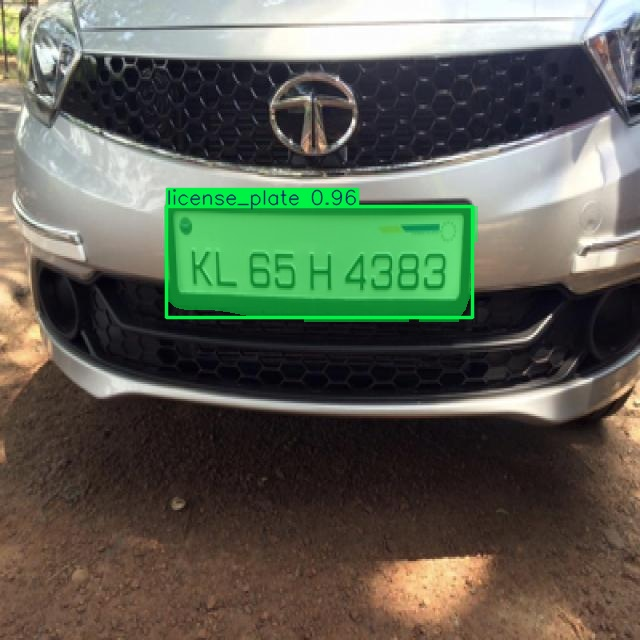

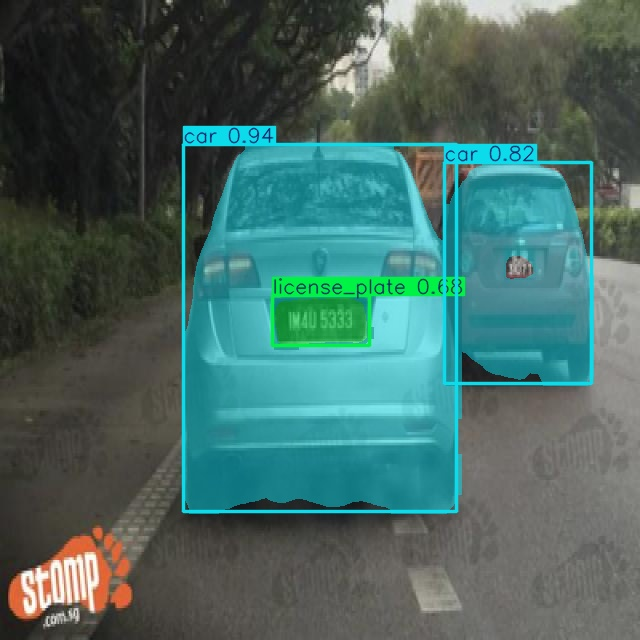

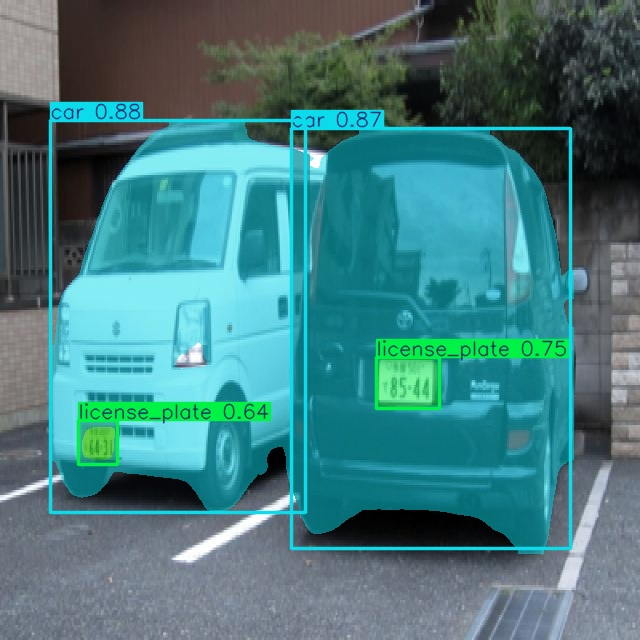

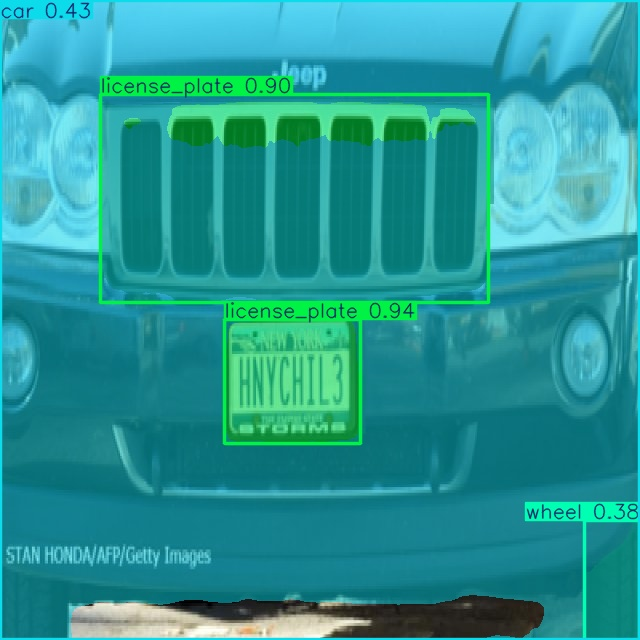

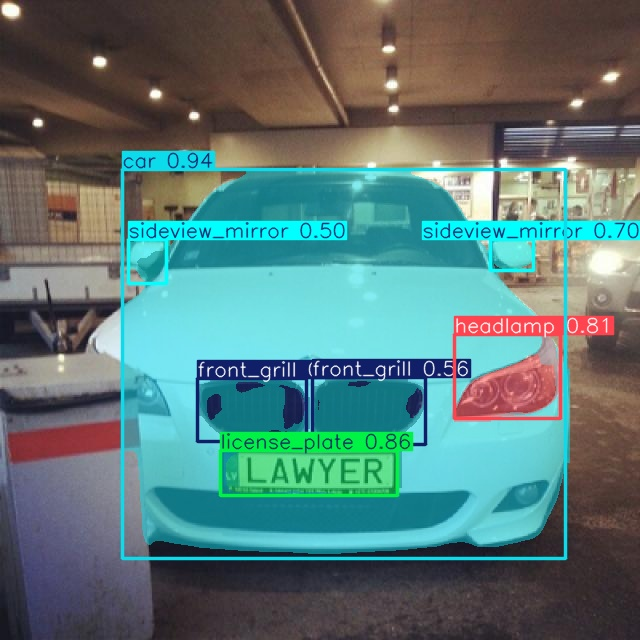

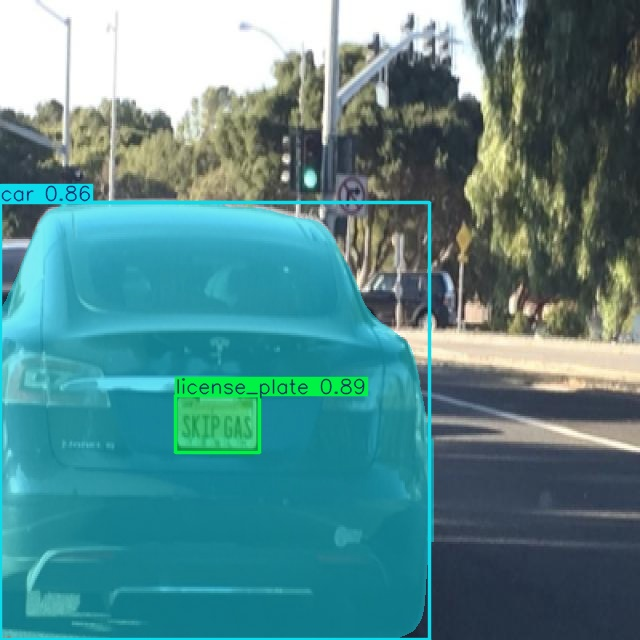

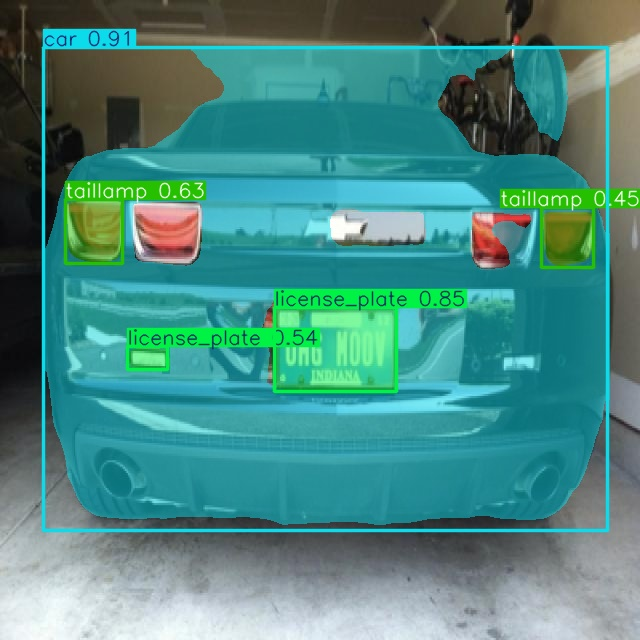

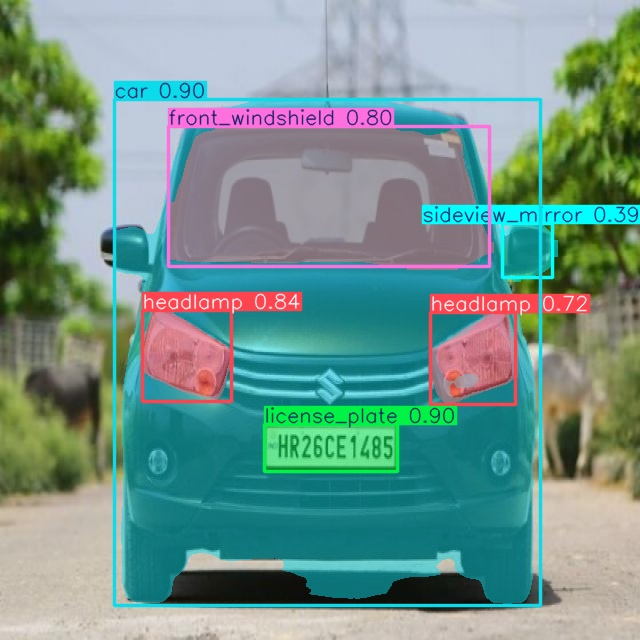

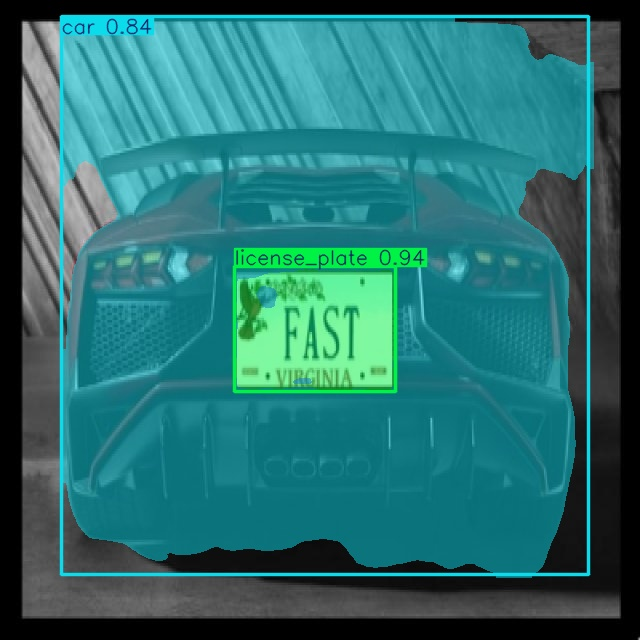

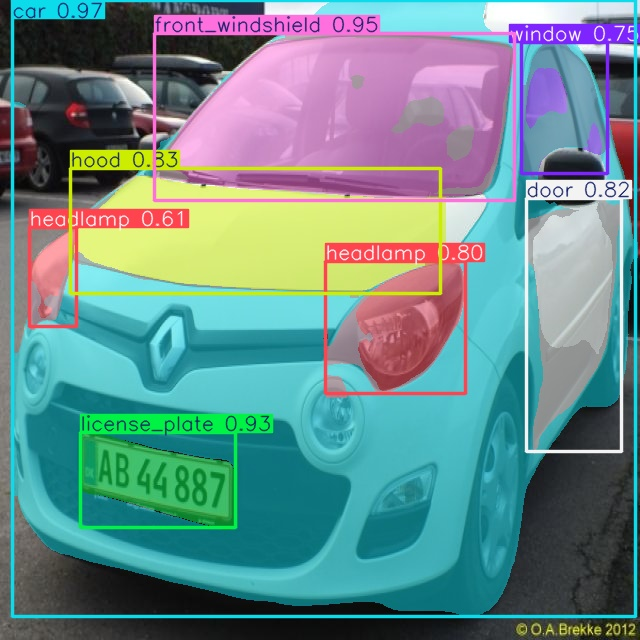

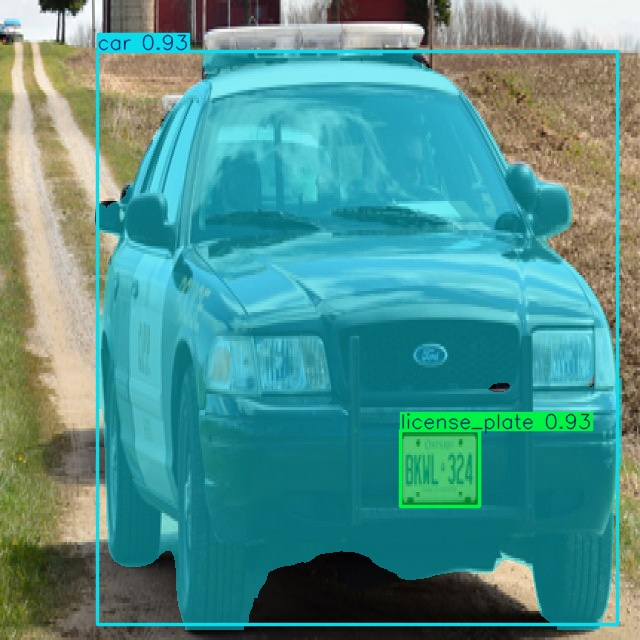

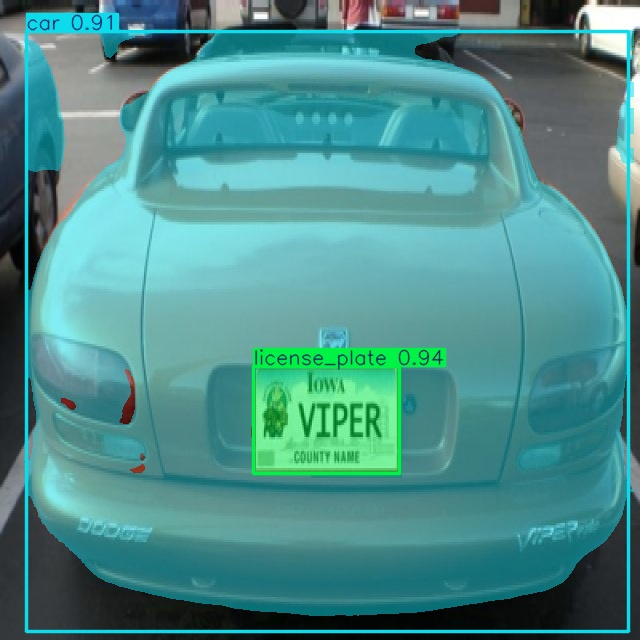

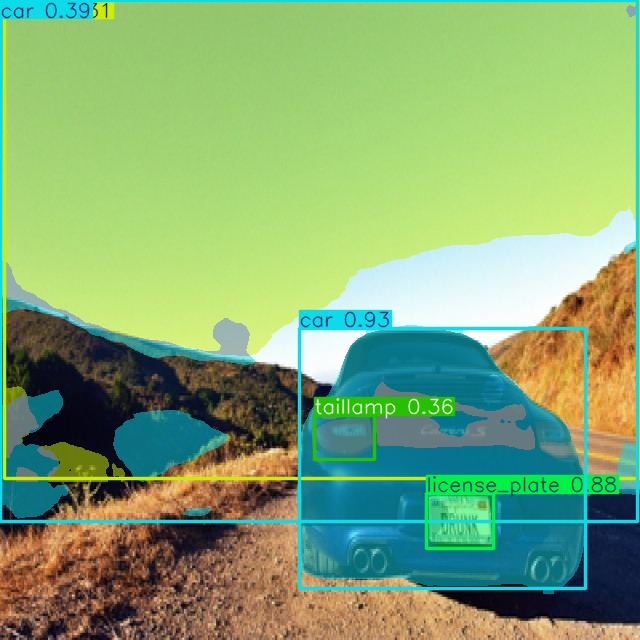

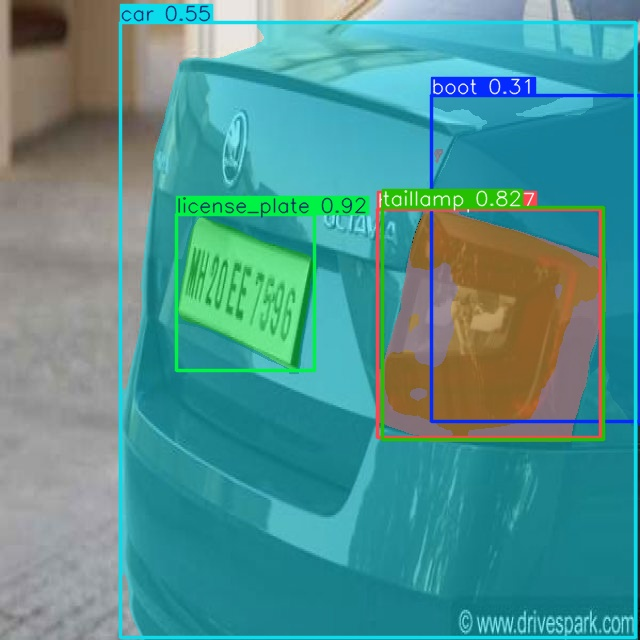

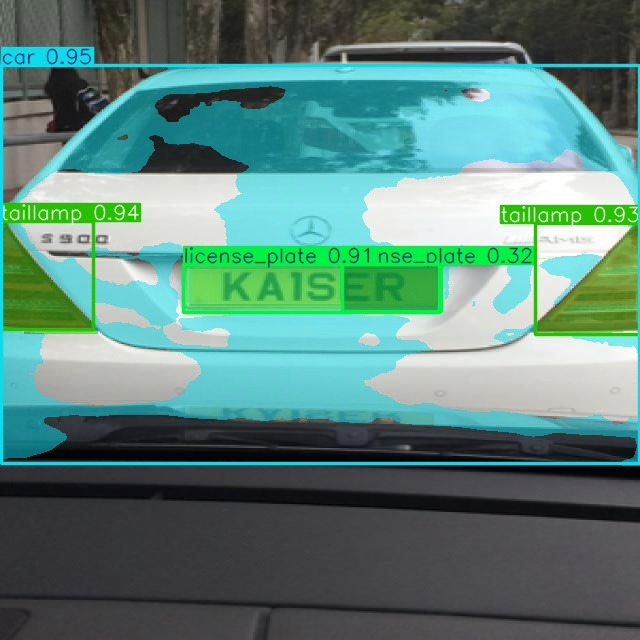

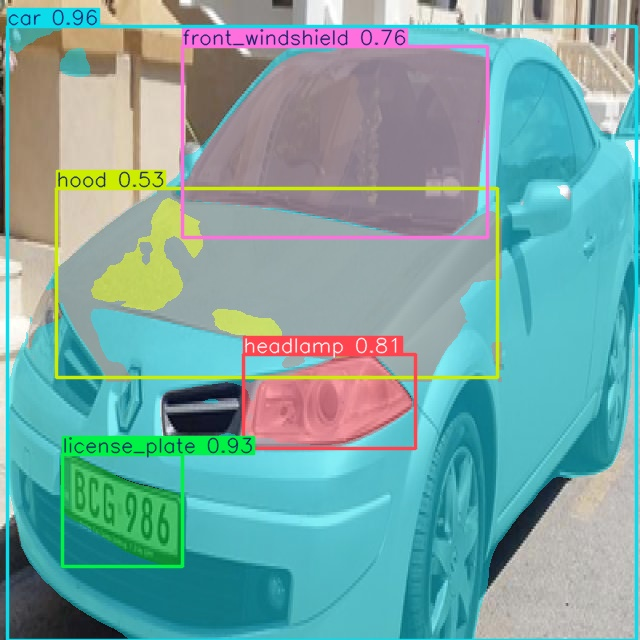

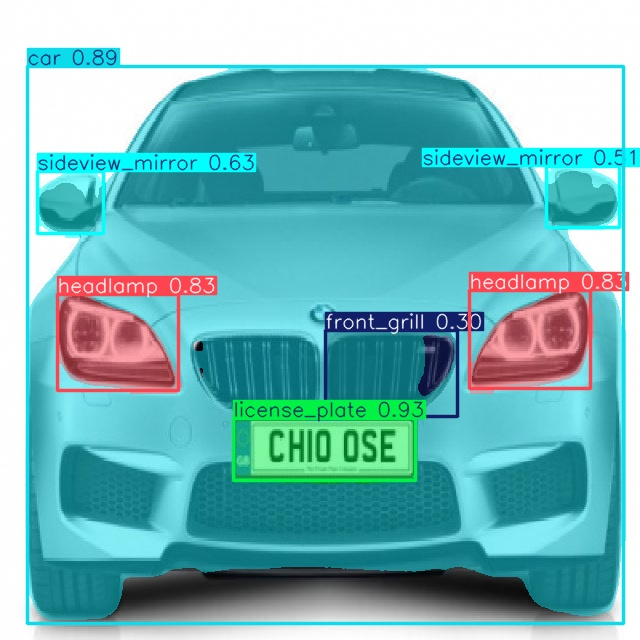

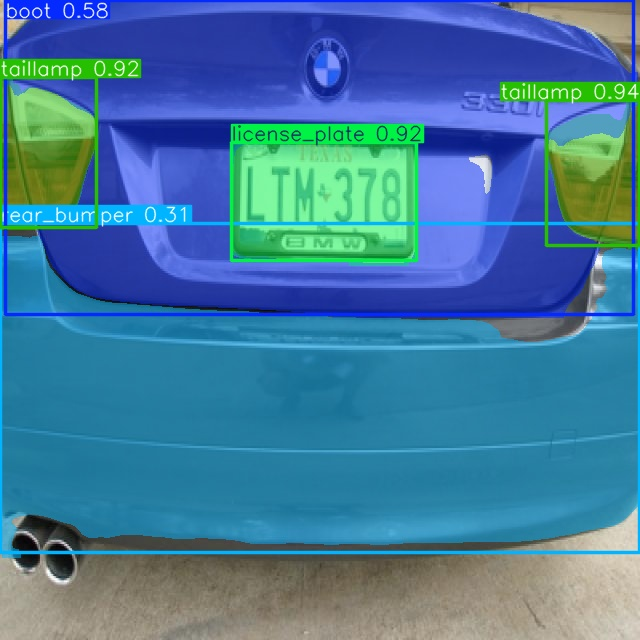

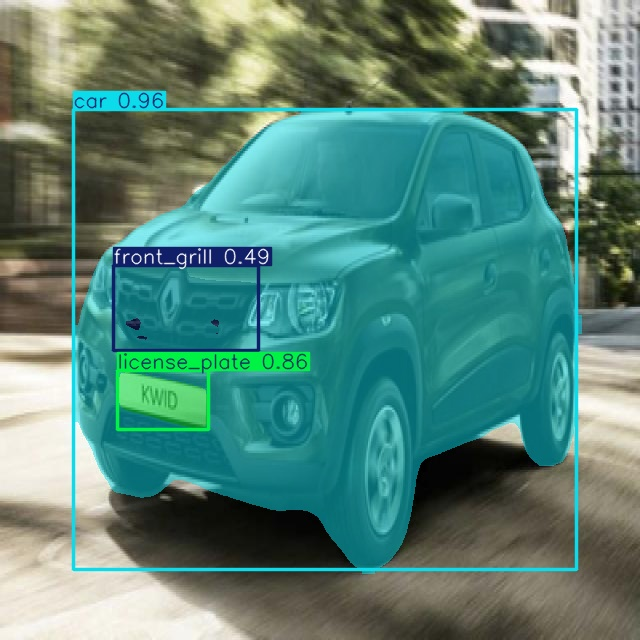

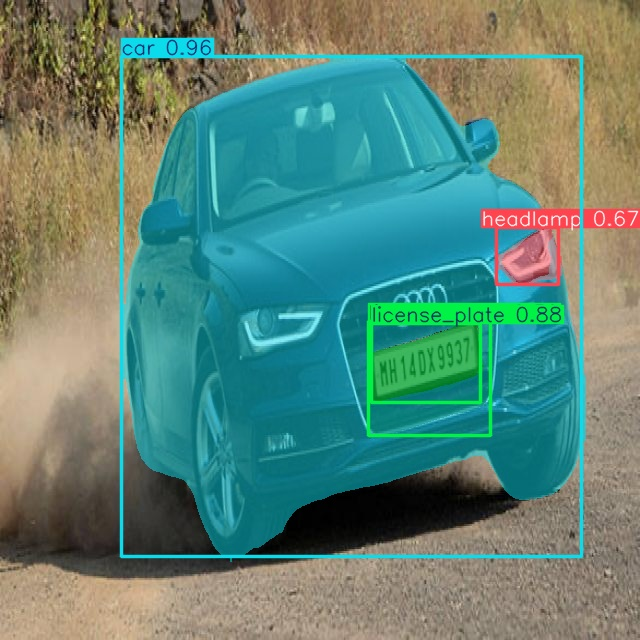

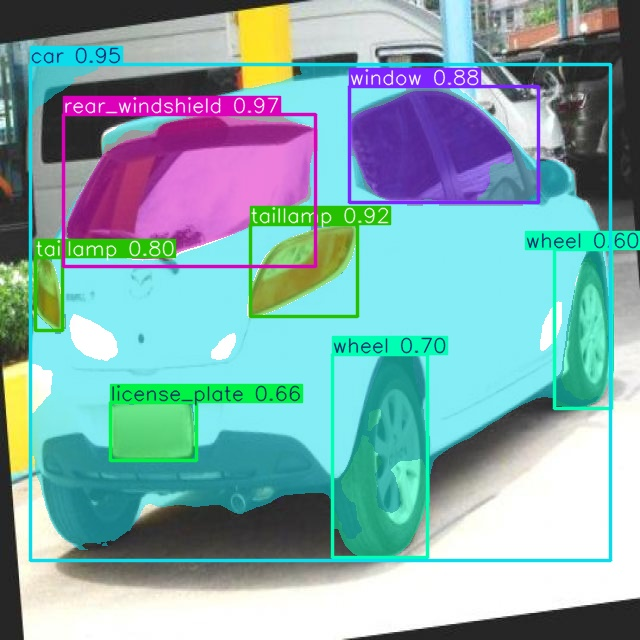

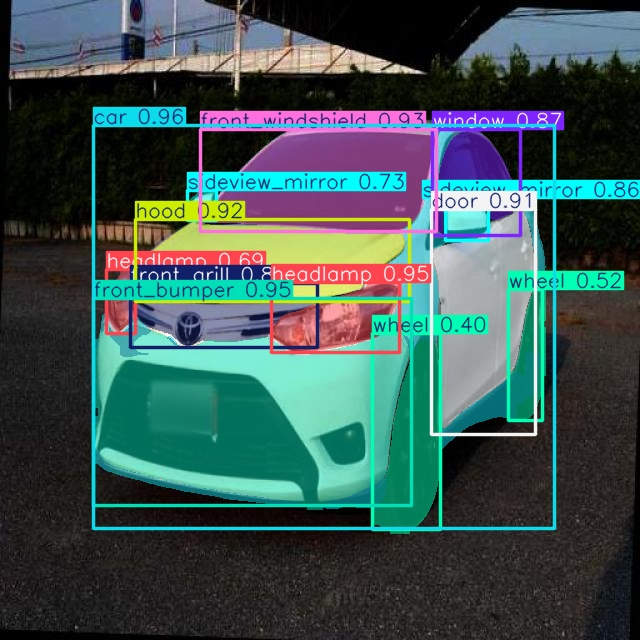

In [ ]:
# View the result

from IPython.display import Image, display

imgdir = "/content/drive/MyDrive/runs/car_parts_seg_test"
for img in os.listdir(imgdir):
    display(Image(filename=f"{imgdir}/{img}"))

In [19]:
# export the model

model.export(format="onnx")


Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/drive/MyDrive/runs/car_parts_seg2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 52, 8400), (1, 32, 160, 160)) (52.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 197ms
Prepared 6 packages in 8.89s
Installed 6 packages in 256ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.82

requirements: AutoUpdate success ✅ 9.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.1 opset 22...


/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 14.0s, saved as '/content/drive/MyDrive/runs/car_parts_seg2/weights/best.onnx' (104.1 MB)

Export complete (16.8s)
Results saved to /content/drive/MyDrive/runs/car_parts_seg2/weights
Predict:         yolo predict task=segment model=/content/drive/MyDrive/runs/car_parts_seg2/weights/best.onnx imgsz=640 
Validate:        yolo val task=segment model=/content/drive/MyDrive/runs/car_parts_seg2/weights/best.onnx imgsz=640 data=/content/data.yaml  
Visualize:       https://netron.app


'/content/drive/MyDrive/runs/car_parts_seg2/weights/best.onnx'

testing on user data

In [32]:
from ultralytics import YOLO
from IPython.display import Image, display
import glob
import os

MODEL_PATH = "/content/drive/MyDrive/runs/car_parts_seg2/weights/best.pt"
TEST_IMAGE = "/content/drive/MyDrive/carimage3.jpg" # test image path

model = YOLO(MODEL_PATH)
print("✅ Model loaded successfully")

results = model.predict(
    source=TEST_IMAGE,
    conf=0.25,
    iou=0.5,
    save=True
)


✅ Model loaded successfully

image 1/1 /content/drive/MyDrive/carimage3.jpg: 384x640 1 car, 1 door, 2 front_grills, 1 front_windshield, 2 headlamps, 1 hood, 1 license_plate, 1 sideview_mirror, 2 wheels, 1 window, 32.3ms
Speed: 2.9ms preprocess, 32.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/segment/predict3


In [44]:
# output the image result
predict_dirs = "runs/segment"

for pred_dir in os.listdir(predict_dirs):
  print(pred_dir)
  latest_predict_dir = pred_dir

print(latest_predict_dir)
# # Get images from latest folder
# output_images = glob.glob(f"{latest_predict_dir}/*.jpg")

# # Display latest image
# display(Image(filename=output_images[0]))

predict2
predict3
.ipynb_checkpoints
.ipynb_checkpoints


In [45]:
# testing on video

model.predict(
    source="/content/drive/MyDrive/carRecordDetect.mp4",
    conf=0.3,
    save=True
)



WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/377) /content/drive/MyDrive/carRecordDetect.mp4: 640x512 1 car, 1 door, 1 front_grill, 1 license_plate, 1 sideview_mirror, 2 wheels, 68.2ms
video 1/1 (frame 2/377) /content/drive/MyDrive/carRecordDetect.mp4: 640x512 1 car, 1 door, 1 license_plate, 1 sideview_mirror, 2 wheels, 34.7ms
video 1/1 (frame 3/377) /content/drive/MyDrive/carRecordDetect.mp4: 640x512 1 car, 1 door, 1 license_plate, 2 wheels, 34.6ms
video 1/1 (frame 4/377) /conte

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'boot', 1: 'car', 2: 'door', 3: 'front_bumper', 4: 'front_grill', 5: 'front_windshield', 6: 'headlamp', 7: 'hood', 8: 'license_plate', 9: 'panel', 10: 'rear_bumper', 11: 'rear_windshield', 12: 'sideview_mirror', 13: 'taillamp', 14: 'wheel', 15: 'window'}
 obb: None
 orig_img: array([[[241, 223, 213],
         [241, 223, 213],
         [241, 223, 213],
         ...,
         [247, 225, 208],
         [190, 171, 152],
         [ 25,   6,   0]],
 
        [[241, 223, 213],
         [241, 223, 213],
         [241, 223, 213],
         ...,
         [247, 225, 208],
         [190, 171, 152],
         [ 25,   6,   0]],
 
        [[242, 224, 214],
         [242, 224, 214],
         [242, 224, 214],
         ...,
         [247, 225, 208],
         [190, 171, 152],
         [ 24,   5,   0]],
 
        ...,
 
   